# Open quesions:
    * What to do with missing days (e.g. 2019-11-28 [Thanksgivbing])
    * Non-unique tickers/isins
    * ~~ --__**L1 and L2 lengths - currently calendar days - should be trading days? - Might make BIG difference when aggregating**__-- ~~
    * Am currently lengthening when Market and Company aren't the same. Is this correct?
    * Also, check what the heck actually is in "company_returns"... Should probably re-understand that code once more...
    * How do we do with periods out of range w.r.t. indexes? - Fix this!
    * Currently always from Company - but should compare with market as well

In [6]:
# Standard
import pandas as pd
import numpy as np
import pickle

# Time Cleaning
import time
import datetime
from dateutil.relativedelta import relativedelta

# Scraping
import requests
import locale
from pandas.io.json import json_normalize
import io

from os.path import exists

import statsmodels.api as sm
from statsmodels import regression


import matplotlib.pyplot as plt

# Import User Defined functions
import source.read_tickers_and_isins as URTI
import source.get_directors_dealings as UGDD
import source.get_timeseries as UGT
import source.analyze_get_summary_of_data as AGSOD
import source.preprocess_directors_dealings as UPDD
import source.preprocess_timeseries as UPTS
import source.preprocess_timeseries_from_excel as UPTFE
import source.analyse_single_company as UASC

# Read in single company to "analyze"

In [7]:
_isin = 'US02376R1023'


NAME = "Knudsen"
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_RAW = DATA_LOCATION + 'raw/insider/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_TIME_SERIES_RAW = DATA_LOCATION + 'raw/timeseries/'
DATA_LOCATION_TIME_SERIES_PROCESSED = DATA_LOCATION + 'processed/timeseries/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI/'

_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED

file_loc = _ri_location + _isin + '.pickle'
with open(file_loc, "rb") as f:
    type = pickle.load(f)
    isin = pickle.load(f)
    name = pickle.load(f)
    ticker = pickle.load(f)
    start_date = pickle.load(f)
    end_date = pickle.load(f)
    return_index_df = pickle.load(f)
#display(return_index_df)

company_return = return_index_df
display(company_return)

# Probably need a try/catch here
insider_data_df = pd.read_csv(_insider_location + ticker + '.csv', index_col=0, parse_dates=['FilingDate', 'TradeDate'])
#display(insider_data_df)


,ReturnIndex
Date,
2016-03-21,179.65
2016-03-22,176.71
2016-03-23,173.24
2016-03-24,167.37
2016-03-25,167.37
...,...
2022-03-10,61.24
2022-03-11,60.46
2022-03-14,61.45


### Get market timeseries - used for "normal returns"

Move this to somewhere that makes sense

Perfect! seems to work

In [8]:
end_time = datetime.datetime(2022, 3, 21, 23, 59, 59)
_end_time_unix = int(time.mktime(end_time.timetuple()))
print(_end_time_unix)

start_time = datetime.datetime(2016, 3, 21, 0, 0, 0)
_start_time_unix = int(time.mktime(start_time.timetuple()))

print(_start_time_unix)
_ticker = '%5EIXIC'

url = f'https://query1.finance.yahoo.com/v7/finance/download/{_ticker}?period1={_start_time_unix}&period2={_end_time_unix}&interval=1d&events=history&includeAdjustedClose=true'

market_timeseries = pd.read_csv(url)
market_timeseries = market_timeseries.set_index('Date')
market_timeseries.index = market_timeseries.index.astype('datetime64[ns]')

market_timeseries

1647903599
1458514800


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-21,4787.310059,4814.850098,4785.379883,4808.870117,4808.870117,1609230000
2016-03-22,4783.600098,4835.600098,4781.709961,4821.660156,4821.660156,1596200000
2016-03-23,4813.870117,4816.669922,4765.370117,4768.859863,4768.859863,1732630000
2016-03-24,4743.359863,4773.500000,4734.770020,4773.500000,4773.500000,1590990000
2016-03-28,4785.250000,4787.390137,4760.009766,4766.790039,4766.790039,1381000000
...,...,...,...,...,...,...
2022-03-15,12685.230469,12973.879883,12616.589844,12948.620117,12948.620117,5414590000
2022-03-16,13119.370117,13440.120117,12992.200195,13436.549805,13436.549805,6498110000
2022-03-17,13360.719727,13620.799805,13317.139648,13614.780273,13614.780273,5575030000


# Define Events windows (PEF_8 page 34)

In [9]:
import sys

# This date will be moved to a loop
## Define which periods we are looking at.
event_timestamp = insider_data_df['FilingDate'][0].floor('d')

## Constants defining how long both Estimation Window and Event Window are - See page 34 in PEF_8
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 20


# Check if we have enough data to run analysis:
## I get a bunch of Out of bounds errors when events happen too close to the border of available data. Did a bunch of cleansing, before realiing that it is WAY easier to just throw errors then.
## Let's see if we can handle this better...

# Constants that are being checked
## We need to have this data:
required_days_before_event = L1_length + L2_length
required_days_after_event = L2_length
VERY_minimum_days_required = required_days_before_event + required_days_after_event + 1 # VERY not relavant at all... - If this fails; the two other checks will as well

## We have this data:
company_length = company_return.shape[0]
market_length = market_timeseries.shape[0]

### This is the location of the event that is being checked:
event_index_company = company_return.index.get_loc(event_timestamp)
event_index_market = market_timeseries.index.get_loc(event_timestamp)

# I want all errors logged, hence a flag - would make way more sense to break in the check itself
ERROR_HAS_OCCURED = 0

# Do worlds most unnecesary check
if (company_length < VERY_minimum_days_required):
    print(f"Analysis can't be done. Requires data length of {VERY_minimum_days_required} trading days. However we only have {company_length} trading days for the company information")
    ERROR_HAS_OCCURED = 1
    
if (market_length < VERY_minimum_days_required):
    print(f"Analysis can't be done. Requires data length of {VERY_minimum_days_required} trading days. However we only have {market_length} trading days for the market information")
    ERROR_HAS_OCCURED = 1

if (required_days_before_event >= event_index_company): # Check if smaller or smaller or equal is correct
    print(f"Analysis can't be done. Requires at least {required_days_before_event} trading days before the event. However we only have {event_index_company} entries prior in the company data")
    ERROR_HAS_OCCURED = 1
          
if (required_days_before_event >= event_index_market): # Check if smaller or smaller or equal is correct
    print(f"Analysis can't be done. Requires at least {required_days_before_event} trading days before the event. However we only have {event_index_market} entries prior in the market data")
    ERROR_HAS_OCCURED = 1

if (required_days_after_event >= (company_length - event_index_company)): # Check if smaller or smaller or equal is correct
    print(f"Analysis can't be done. Requires at least {required_days_after_event} trading days AFTER the event. However we only have {(company_length - event_index_company)} entries available after in the company data")
    ERROR_HAS_OCCURED = 1
    
if (required_days_after_event >= (market_length - event_index_market)): # Check if smaller or smaller or equal is correct
    print(f"Analysis can't be done. Requires at least {required_days_after_event} trading days AFTER the event. However we only have {(market_length - event_index_market)} entries available after in the market data")
    ERROR_HAS_OCCURED = 1

if ERROR_HAS_OCCURED == 1:
    raise SystemExit("You saw it already - we've got errors and shite!") # Switch to break or return once I'm done playing around

# Yay! If you've come this far; we can start the analysis!


# Event-Window (L2):
## Discard this solution - this takes calendar-days; should be trading days!
#T1 = event_timestamp - datetime.timedelta(days = L2_length)
#T2 = event_timestamp + datetime.timedelta(days = L2_length)

T1_c_iloc = company_return.index.get_loc(event_timestamp)-L2_length
T1_m_iloc = market_timeseries.index.get_loc(event_timestamp)-L2_length

# Fairly certain this block can be deleted now that I've implemented the checks above...
#if T1_c_iloc < 0:
#    T1_c_iloc = 0
    
#if T1_m_iloc < 0:
#    T1_m_iloc = 0

T1_c = company_return.index[T1_c_iloc]
T1_m = market_timeseries.index[T1_m_iloc]

# Do this magic BEFORE calculating T0 - Otherwise we risk breaking!
if (T1_c < T1_m):
    T1 = T1_c
else:
    T1 = T1_m

print(f'Found T1: {str(T1)}')
    
T2_c_iloc = company_return.index.get_loc(event_timestamp)+L2_length
T2_m_iloc = market_timeseries.index.get_loc(event_timestamp)+L2_length

# Fairly certain this block can be deleted now that I've implemented the checks above...
#if T2_c_iloc > company_return.shape[0]-1:
#    T2_c_iloc = company_return.shape[0]-1
    
#if T2_m_iloc > market_timeseries.shape[0]-1:
#    T2_m_iloc = market_timeseries.shape[0]-1

T2_c = company_return.index[T2_c_iloc]
T2_m = market_timeseries.index[T2_m_iloc]

if (T2_c > T2_m):
    T2 = T2_c
else:
    T2 = T2_m

print(f'Found T2: {str(T2)}')

# Estimation Window:
#T0 = T1 - datetime.timedelta(days = L1_length)

T0_c_iloc = company_return.index.get_loc(T1)-L1_length
T0_m_iloc = market_timeseries.index.get_loc(T1)-L1_length

# Fairly certain this block can be deleted now that I've implemented the checks above...
#if T0_c_iloc < 0:
#    T0_c_iloc = 0
    
#if T2_m_iloc < 0:
#    T2_m_iloc = 0

T0_c = company_return.index[T0_c_iloc]
T0_m = market_timeseries.index[T0_m_iloc]

if (T0_c < T0_m):
    T0 = T0_c
else:
    T0 = T0_m
    
print(f'Found T0: {str(T0)}')

## Break T0 and T1 to cheat so we don't start with NAs
#T1_ = T1 - datetime.timedelta(days = 1)
#T0_ = T0 - datetime.timedelta(days = 1)
T1_ = company_return.index[company_return.index.get_loc(T1)-1]
T0_ = company_return.index[company_return.index.get_loc(T0)-1]


print(f'------------------------------')
print(f'Event occurred at             {event_timestamp}')
print(f'Estimation Window ({str(L1_length)} days): from {str(T0)} to {str(T1)}')
print(f'Event Window      ( {str(L2_length)} days): from {str(T1)} to {str(T0)}')

# Cut return timeseries into correct periods

## Estimation Window
### For estimating alphas and betas
estimation_window_index_market = (market_timeseries.index >= T0_) & (market_timeseries.index < T1)
estimation_window_index_company = (company_return.index >= T0_) & (company_return.index < T1)

estimation_window_market_timeseries = market_timeseries[estimation_window_index_market]
estimation_market_count = estimation_window_market_timeseries.shape[0]

estimation_window_company_timeseries = company_return[estimation_window_index_company]
estimation_company_count = estimation_window_company_timeseries.shape[0]

## Event-Window
event_window_index_market = (market_timeseries.index >= T1_) & (market_timeseries.index < T2)
event_window_index_company = (company_return.index >= T1_) & (company_return.index < T2)

event_window_market_timeseries = market_timeseries[event_window_index_market]
event_market_count = event_window_market_timeseries.shape[0]

event_window_company_timeseries = company_return[event_window_index_company]
event_company_count = event_window_company_timeseries.shape[0]

print('shape before aggregating')
print(f'# estimation_window_market_timeseries: {estimation_window_market_timeseries.shape}')
print(f'# estimation_window_company_timeseries: {estimation_window_company_timeseries.shape}')
print(f'# event_window_market_timeseries: {event_window_market_timeseries.shape}')
print(f'# event_window_company_timeseries: {event_window_company_timeseries.shape}')


# Unify indexing, so that both contain same amount of trading days.
if (estimation_company_count > estimation_market_count):
    idx = estimation_window_company_timeseries.index
    estimation_window_market_timeseries = estimation_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_market_timeseries['Adj Close'] = estimation_window_market_timeseries['Adj Close'].fillna(method='ffill')
if (estimation_market_count > estimation_company_count):
    idx = estimation_window_market_timeseries.index
    estimation_window_company_timeseries = estimation_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    estimation_window_company_timeseries['ReturnIndex'] = estimation_window_company_timeseries['ReturnIndex'].fillna(method='ffill')


# Unify indexing, so that both contain same amount of trading days.
if (event_company_count > event_market_count):
    idx = event_window_company_timeseries.index
    event_window_market_timeseries = event_window_market_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_market_timeseries['Adj Close'] = event_window_market_timeseries['Adj Close'].fillna(method='ffill')
if (event_market_count > event_company_count):
    idx = event_window_market_timeseries.index
    event_window_company_timeseries = event_window_company_timeseries.reindex(idx, fill_value = np.NaN)
    # Fill missing with previous observation
    event_window_company_timeseries['ReturnIndex'] = event_window_company_timeseries['ReturnIndex'].fillna(method='ffill')
# Calculate percentage returns
estimation_window_market_return = estimation_window_market_timeseries['Adj Close'].pct_change()
estimation_window_company_return = estimation_window_company_timeseries['ReturnIndex'].pct_change()

event_window_market_return = event_window_market_timeseries['Adj Close'].pct_change()
event_window_company_return = event_window_company_timeseries['ReturnIndex'].pct_change()

## Remove the fake first date
estimation_window_market_return = estimation_window_market_return.iloc[1:]
estimation_window_company_return = estimation_window_company_return.iloc[1:]

event_window_market_return = event_window_market_return.iloc[1:]
event_window_company_return = event_window_company_return.iloc[1:]

print('shape after aggregating')
print(f'# estimation_window_market_return: {estimation_window_market_return.shape}')
print(f'# estimation_window_market_return: {estimation_window_market_return.shape}')
print(f'# event_window_market_return: {event_window_market_return.shape}')
print(f'# event_window_company_return: {event_window_company_return.shape}')

# Calculate coefficients

X = estimation_window_market_return.values
Y = estimation_window_company_return.values

def linreg(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    
    print(model.summary())
    
    # Remove the constant
    x = x[:,1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)

print(f'alpha: {str(alpha)}')
print(f'beta: {str(beta)}')

Found T1: 2020-02-03 00:00:00
Found T2: 2020-03-31 00:00:00
Found T0: 2019-09-10 00:00:00
------------------------------
Event occurred at             2020-03-03 00:00:00
Estimation Window (100 days): from 2019-09-10 00:00:00 to 2020-02-03 00:00:00
Event Window      ( 20 days): from 2020-02-03 00:00:00 to 2019-09-10 00:00:00
shape before aggregating
# estimation_window_market_timeseries: (101, 6)
# estimation_window_company_timeseries: (105, 1)
# event_window_market_timeseries: (41, 6)
# event_window_company_timeseries: (42, 1)
shape after aggregating
# estimation_window_market_return: (104,)
# estimation_window_market_return: (104,)
# event_window_market_return: (41,)
# event_window_company_return: (41,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statis

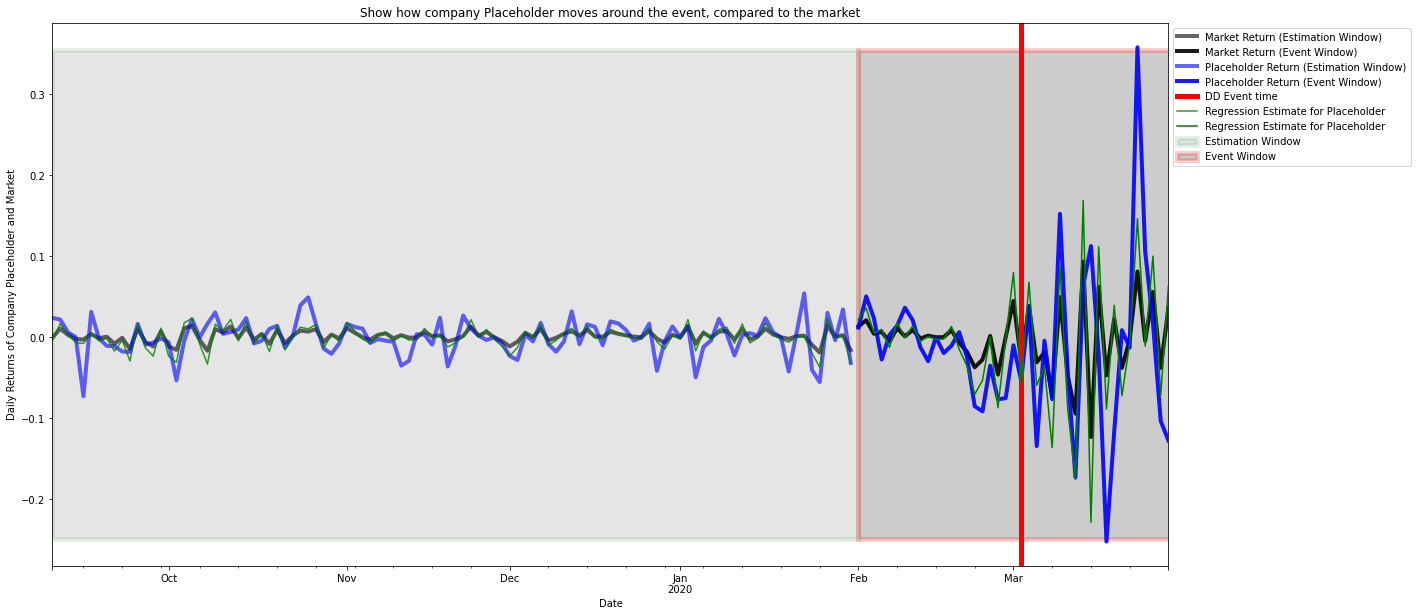

I'm impressed! It looks like a five-year-old drew this plot in paint


In [10]:
Company_name = 'Placeholder'

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha


plt.figure(figsize=(20,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns of Company {Company_name} and Market')
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company {Company_name} moves around the event, compared to the market')
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")